<center>
    <h1> ILI-286 - Laboratorio #1 </h1>
    <h2> Computación numérica de vectores propios aplicados a PCA </h2>
</center>

| Nombre | Rol | Email |
| :----- | :-- | :---- |
| Marco Rojas | 201073005-0 | marco.rojaso@alumnos.usm.cl |
| Hernán Vargas | 201073009-3 | hernan.vargas@alumnos.usm.cl |


## Tabla de contenidos
* [Introducción](#intro)
* [Desarrollo y analisís de resultados:](#desarrollo)
 1. [Power Iteration y Rayleigh Quotient](#de1)
 2. [Naive k-first eigen finder](#de2)
 3. [Clever k-first eigen finder](#de3)
 4. [Modificación a Normalized Simultaneous Iteration](#de4)
 5. [Power iteration v/s Rayleigh Quotient iteration](#de5)
 6. [Naive k-eigen finder v/s Clever k-eigen finder v/s k-eigen Normalized Simultaneous Iteration](#de6)
 7. [Todos los valores y vectores propios](#de7)
* [Concluciones](#Concluciones)
* [Referencias](#Referencias)

<div id='intro' />
## Introducción
En este laboratorio se analizarán diversos algoritmos para el cálculo de valores y vectores propios.
De su implementación se calculará su complejidad y se harán comparaciones para obtener concluciones sobre su desempeño y exactitud.

Como muestra se utilizará un *dataset* de 700 mediciones con 2500 caracteristicas. 
Como muchos algoritmos requieren una matriz cuadrada para operar se trabajará sobre la matriz de covarianzas que resultará ser $A_{n\times n}$ con $n=2500$, pues el calculo de los valores propios de ésta es muy útil para el *Principal Component Analisis* y lograr identificar los componentes principales.

Como notamos, al trabajar con una matriz de $2500\times 2500$ los tiempos que requerirán nuestros algoritmos para encontrar todos los valores y vectores propios serán muy largos así que buscamos metodos que evadan este proceso y solo encuentren los más relevantes.

<div id='desarrollo'/>
## Desarrollo y analisís de resultados

Debemos comenzar cargando las bibliotecas y datos necesarios. Además se definirán algunas variables que se usarán más adelante.

In [1]:
import numpy as np
#Para utilizar %memit
%load_ext memory_profiler
from matplotlib import pyplot as plt
%matplotlib inline

dataset = np.load("arcene.npy")
sigma_x = np.dot((1/(1-dataset.shape[1]))*np.transpose(dataset), dataset)

def normalize(A):
    return np.divide(A,(np.linalg.norm(A)))

Además como se calcularán las complejidades de varios algoritmos se debe tener en cuenta lo siguiente:

La multiplicación de una matriz $A_{n\times m}$ por $B_{m\times p}$ tiene complejidad $O(nmp)$. En este caso trabajamos con matrices cuadradas y vectores así que nuestra complejidad del producto matriz - vector será: $O(n^2)$

La normalización de una matriz $A_{n\times m}$ incluye una multiplicación de matriz por escalar y una división por la norma de una matriz. 
La multiplicación y la división tendrá complejidad $O(n^2)$ para las matrices $A_{n\times n}$.
La norma que consiste en elevar cada elemento ($O(n^2)$), sumarlos ($O(n^2)$) y sacar la raíz cuadráda ($\sim O(n)$) de esta suma. Así la norma tambien tendrá complejidad de $O(n^2)$ y por ello el proceso de normalización tendrá complejidad de $O(n^2)$


La normalización de una matriz $A_{n\times m}$ incluye una multiplicación de matriz por escalar y una división por la norma de una matriz. 
La multiplicación y la división tendrá complejidad $O(n^2)$ para las matrices $A_{n\times n}$.
La norma que consiste en elevar cada elemento ($O(n^2)$), sumarlos ($O(n^2)$) y sacar la raíz cuadráda ($\sim O(n)$) de esta suma. Así la norma tambien tendrá complejidad de $O(n^2)$ y por ello el proceso de normalización tendrá complejidad de $O(n^2)$

Además podemos notar que la complejidad de calcular la transpuesta de $A_{n\times n}$ será $O(n^2)$

Por último, la complejidad de `numpy.linalg.solve` es de $O(n^3)$ pues utiliza el algoritmo *LAPACK*[[1](#ref1)] podemos ver su complejidad en [[2](#ref2)]

<div id='de1'/>
### 1.- Power Iteration y Rayleigh Quotient Iteration

Los siguientes algoritmos requieren una matriz $A_{n\times n}$.
Opcionalmente pueden recibir el vector inicial $x_{n\times 1}$ (por defecto $[1 \dots 1]^{T}$) y un número máximo de iteraciones (por defecto $1000$).

Adicionalmente *Rayleigh Quotient Iteration* necesita una función que resuelva sistemas de ecuaciones $Ax = b$, por ello tiene como argumento opcional una función (`solve`) que reciba la tupla $(A,b)$ y retorne $x$. Por defecto se utiliza `numpy.linalg.solve` pues es la más general.

Ambos algoritmos retornan una tupla con el valor y vector propio dominante: $(\lambda, \vec{v})$

In [2]:
def power_iteration(A, x=None, max_iter=1000):
    #Comprueba las dimensiones de x.
    if x is None: x = np.ones([A.shape[0],1])
    elif A.shape[0] != x.shape[0]: raise ValueError("Initial vector error.")
    #Bucle de resolución.
    lamb_old = False
    for j in range(1, max_iter):
        u = normalize(x)
        x = np.dot(A,u)
        lamb = np.dot(np.transpose(u),x)
        if (lamb == lamb_old): break
        lamb_old = lamb
    u = normalize(x)
    return lamb[0,0], u

def rayleigh_quotient_iteration(A, x=None, max_iter=1000, solve=np.linalg.solve):
    #Comprueba las dimensiones de x.
    if x is None: x = np.ones([A.shape[0],1])
    elif A.shape[0] != x.shape[0]: raise ValueError("Initial vector error.")
    #Bucle de resolución.
    I = np.identity(A.shape[0])
    lamb_old = False
    for i in range(1, max_iter):
        u = normalize(x)
        lamb = np.dot(np.dot(np.transpose(u), A), u)
        C = A - lamb*I
        try:
            x = solve(C, u)
        except np.linalg.LinAlgError as e:
            if(str(e) == "Singular matrix"): break 
            else: raise
        if (lamb == lamb_old): break
        lamb_old = lamb
    u = normalize(x)
    return lamb[0,0], u

#### a) Complejidad algoritmo Power Iteracion: 
En el bucle principal de *Power Iteration* se realiza una normalización, dos productos matriz - vector y una transpuesta, así su complejidad será: $k(O(n^2) + 2O(n^2) + O(n^2)) = O(kn^2)$
     
Como vemos, la complejidad de *Power Iteration* viene dada principalmente por la cantidad de iteraciones $k$ que alcance a realizar antes de converger. Como la tasa de convergencia de este algoritmo es lineal se espera que $k$ sea grande.
     
     
#### b) Complejidad algoritmo Rayleigh Quotient Iteration:
El bucle principal de *Rayleigh Quotient Iteration* efectua una normalización, una transpuesta, dos productos puntos y un *solve*, así su complejidad estará dada por: $k(4O(n^2) + O(n^3)) = O(kn^3)$
     
$k$ al igual que en el caso anterior representa la cantidad de iteraciones que alcanza a realizar el algoritmo, este $k$ será mucho menor (convergencia cuadrática) que en *power iteration* pues el algoritmo hace converger el vector propio más rapidamente especialmente cuando la matris $A$ es simetrica (convergencia cúbica).
 

<div id='de2'/>
### 2.- Naive k-first eigen finder
#### a) Correctitud:

Llamemos $B = A - \lambda_1 v_1 v_1^T$, supongamos $A$ simetrica y por ello sus vectores propios ortogonales. Calcularemos los vectores y valores propios de B:
$$ B v_i = (A - \lambda_1 v_1 v_1^T)v_i$$
$$ B v_i = Av_i - \lambda_1 v_1 v_1^Tv_i$$

Luego, digamos $v_i$ unitario por lo que para $i=1$ tenemos $ v_1^T v_i = 1$ y  para $i\neq 1$ tenemos que $ v_1^T v_i = 0 $ 

Así, $B v_i = \lambda_i v_i $ para $i=2:n$

Es decir, los valores y vectores propios de $B$ con respecto a $A$ son iguales a excepción del primer valor propio de $B$ que es 0 a diferencia de $A$. Entonces podemos usar ésta propiedad para calcular los valores propios dominantes i-ésimos de $A$ con *Power Iteration* u otro algoritmo de búsqueda de valor propio dominante.

#### b) Complejidad del algoritmo kEigenFinder:
En el bucle principal de `kEigenFinder` se realiza una transpuesta, un producto punto, una resta y un *power iteration*,
así, suponiendo que $k_1$ es el número de valores y vectores propios a obtener y $k_2$ es el promedio de iteraciones de *power iteration* tenemos que la complejidad del algoritmo será: $k_1(3O(n^2 + O(k_2n^2))) = O(k_1k_2n^2)$

#### c) Implementación:
`kEigenFinder` toma como argumento una matriz simetrica $A_{n\times n}$. Opcionalmente un número $k$ de valores y vectores propios a obtener (por defecto todos) y un número máximo de iteraciones `max_iter` y vector $p$ inicial para cada ejecución de *power iteration*.

Retorna un `array` con valores propios y una matriz con vectores propios.

In [3]:
def kEigenFinder(A, k = None, p = None, max_iter=1000):
    if p is None: p = np.ones([A.shape[0],1])
    elif A.shape[0] != p.shape[0]: raise ValueError("Initial vector error.")
    if k is None: k = A.shape[0]
    elif k > A.shape[0]: raise ValueError("k is out of range.")
    
    lamb = np.zeros([p.shape[0],1])
    l = 0
    v_finales = np.zeros([p.shape[0], p.shape[0]])
    v = np.zeros([p.shape[0], 1])
    for j in range(0, k):
        A = A-l*np.dot(v,v.transpose())
        l, v = power_iteration(A, p, max_iter)
        v_finales[:,[j]] = v
        lamb[j] = l
    return lamb, v_finales

<div id='de3'/>
### 3.- Clever k-first eigen finder
#### a) Correctitud

Llamemos $B = A^p - \lambda_1^p v_1 v_1^T$, supongamos $A$ simétrica y por ello sus vectores propios ortogonales. Calcularemos los vectores y valores propios de B:
$$ B v_i = (A^p - \lambda_1^p v_1 v_1^T)v_i$$
$$ B v_i = A^p v_i - \lambda_1^p v_1 v_1^Tv_i$$

Luego, sabemos que $v_i$ es unitario y ortogonal a los otros $v_j$ por lo que para $i=1$ tenemos $ v_1^T v_i = 1$ y  para $i\neq 1$ tenemos que $ v_1^T v_i = 0 $ 

Así, $B v_i = \lambda_i^p v_i $ para $i=2:n$

Es decir, los valores y vectores propios de $B$ con respecto a $A$ son los mismos elevados a $p$ a excepción del primer valor propio de $B$, pero este no es tomado en el algoritmo ya que en ese caso se hace $\lambda = 0$. Luego así se van calculado los valores y vectores propios uno a uno por cada iteración.
#### b) Complejidad algoritmo kEigenFinderPP:
Con una matriz $A_{n\times n}$ tenemos que la complejidad estará dada por las operaciones dentro del bucle principal. Tenemos cuatro productos matriz vector, dos transpuestas, una normalización y una resta.

Así,la complejidad de kEigenFinderPP para encontrar $k$ valores propios será: 
    $k(4n^2 + 2n^2 + 2n^2) ~= O(kn^2)$

#### c) Implementación

In [4]:
def kEigenFinderPP(A, p = 5, k = None):
    if k is None: k = A.shape[0]
    elif k > A.shape[0]: raise ValueError("k is out of range.")
    #Listas donde se guardarán los resulados.
    lamb = [None] * k
    v    = [None] * k
    #Valores iniciales.
    A_p  = np.linalg.matrix_power(A, p)
    #x = np.random.random([A.shape[0],1])
    x = np.ones([A.shape[0],1])
    #Bucle de resolución.
    for i in range(0, k):
        x = np.dot(A_p, x)
        v[i] = normalize(x)
        lamb[i]= np.dot(np.dot(np.transpose(v[i]), A), v[i])[0,0]
        A_p = A_p - lamb[i]**p * np.dot(v[i], np.transpose(v[i])) #Esto se ejecuta una vez demás
    return lamb, v

<div id='de4'/>
### 4.- Modificación a Normalized Simultaneous Iteration
#### a) ¿Que debemos modificar?
Para lograr que Normalized Simultaneous Iteration sólo nos entregue los $k$ primeros valores y vectores propios sin hacer cálculos de más, debemos lograr que $diag((Q' \cdot A) \cdot Q)$ nos entregue sólo $k$ elementos.
Para esto $(Q' \cdot A)\cdot Q$ debe ser una matriz de $k \times k$  por lo cual $Q$ no debe ser de $m\times m$, si no que de $m \times k$ de manera que al hacer $Q' \cdot A$ obtengamos una matriz de $k \times m$ y obtengamos la anterior matriz de $k \times k$ en $(Q' \cdot A) \cdot Q$.

Entonces para lograr esto truncamos nuestra matriz inicial $Q$ a $Q =[:,0:k]$ permitiendo así solo calcular valores para obtener nuestros k valores propios.
#### b) Complejidad computacional
La complejidad es la de hacer la factorización QR $p$ veces:
$$ p \frac {2} {3} n^3 = O(pn^3)$$
#### c) Implementación
El algorirtmo *normalized_simultaneous_iteration_q* recibe como parámetros una matriz $A_{n\times n}$, un número $k$ de valores propios a calcular (por defecto todos) y opcionalmente una cantidad máxima de iteraciones (por defecto 1000)

Retorna una lista con los valores y vectores propios requeridos.

In [5]:
def normalized_simultaneous_iteration(A, max_iter=1000):
    Q = np.identity(A.shape[0])
    for j in range (1,max_iter):
        Q, R = np.linalg.qr(np.dot(A,Q))
    return np.diag(np.dot(np.dot(np.transpose(Q), A),Q))

def normalized_simultaneous_iteration_q(A, k=None, max_iter=1000):
    if k == None: k = A.shape[0]
    elif k > A.shape[0]: raise ValueError("k is out of range.")

    Q = np.identity(A.shape[0]);
    Q = Q[:,0:k]
    Q_old = False
    for j in range (1, max_iter):
        Q, R = np.linalg.qr(np.dot(A,Q))
        if (np.allclose(Q_old, Q)):
            break
        if (j>1):
            Qc = Q_old*Q.transpose()
        Q_old = Q
    return [np.diag(np.dot(np.dot(np.transpose(Q), A),Q)), Q_old]

**Nota: La ejecución de los siguientes códigos es lenta, úsese con precaución.**
<div id='de5'/>
### 5.- Power iteration v/s Rayleigh Quotient iteration.
##### Comparación de tiempos:

In [ ]:
#Si la matriz es simetrica y positiva definida podemos usar el solve de scipy.
#import scipy.linalg 
#sym_solve = lambda A, b: scipy.linalg.solve(A,b,sym_pos=True)
iters = 10
%timeit power_iteration(sigma_x, max_iter=iters)
%timeit rayleigh_quotient_iteration(sigma_x, max_iter=iters)

Debido a la complejidad de la operación para la matriz de $2500\times 2500$ se utilizó un número de iteraciones máximo igual a 10.

En el computador que se trabajó obtuvimos:
```
power_iteration:  10 loops, best of 3: 96.4 ms per loop
rayleigh_quotient: 1 loops, best of 3: 46.8 s per loop
```
Como podemos ver *power iteration* es mucho más rapido que *rayleigh quotient*, al contrario de lo que se esperaría teóricamente (la matriz es simetrica así que *rayleigh* debería converger cúbicamente). Esto se debe a que en cada iteración de *rayleigh quotient iteration* se resuelve el sistema de ecuaciones respectivo, en este caso para una matriz con $2500$ variables. Para la resolución se utiliza por defecto `numpy.linalg.solve` que internamente utiliza un algoritmo de complejidad $O(n^3)$, es decir: prácticamente es lo mismo que sacar la inversa en cada paso.

Si bien la ventaja de *rayleigh power iteration* es su tasa de convergencia, estos efectos no pueden ser notados a no ser que contemos con un algoritmo que aproveche las caracteristicas de la matriz inicial. Por otro lado el desempeño de *power iteration* es bueno debido a que evita hacer operaciones complejas y, aunque su convergencia es lineal, logra hacer muchas iteraciones en poco tiempo.

#### Comparación de memoria:

In [ ]:
%memit  power_iteration(sigma_x, max_iter=iters)
%memit  rayleigh_quotient_iteration(sigma_x, max_iter=iters)

Los resultados en nuestra maquina fueron:
```
peak memory: 115.98 MiB, increment: 0.03 MiB
peak memory: 265.47 MiB, increment: 149.49 MiB
```
Como podemos notar nuevamente *power iteration* vence a *rayleigh quotient iteration* suponemos debido a las razones nombradas anteriormente, la memoria gastada debe ser en el proceso de resolución de de la matriz.

Cabe destacar que en esta ocasión el resultado es el esperado. El proceso de resolución del sistema de ecuaciones gasta más memoria por ciclo. Si la velocidad fuera la correcta esta carácteristica se compensaría con la tasa de convergencia.

<div id='de6'/>
### 6.- Naive k-eigen finder v/s Clever k-eigen finder v/s k-eigen Normalized Simultaneous Iteration
#### Comparación de tiempos:

In [ ]:
K = [10, 100, 1000]
P = 8 #Potencia a elevar
for k in K:
    print("Para k=", k)
    %timeit kEigenFinder(sigma_x, k, max_iter=iters)
    %timeit kEigenFinderPP(sigma_x, P, k)
    %timeit normalized_simultaneous_iteration_q(sigma_x, k, max_iter=iters)

El resultado obtenido fue:
```
Para k= 10
1 loops, best of 3: 3.08 s per loop
1 loops, best of 3: 45 s per loop
1 loops, best of 3: 939 ms per loop
Para k= 100
1 loops, best of 3: 30.7 s per loop
1 loops, best of 3: 1min 43s per loop
1 loops, best of 3: 6.84 s per loop
Para k= 1000
1 loops, best of 3: 5min 5s per loop
1 loops, best of 3: 11min 26s per loop
1 loops, best of 3: 1min 42s per loop
```
Podemos notar de la ejecución de los algoritmos que el que obtiene los mejores resultados es el *normalized simultaneous iteration* debido a que la modificación hecha hace que aumentar la cantidad de valores propios buscados solo signifique hacer descomposiciones qr de una matriz más grande. Por otro lado el algoritmo más lento es el `kEigenFinderPP` probablemente debido a errores de implementación. `kEigenFinder` sigue teniendo un desempeño aceptable debido a su simpleza.

De estos resultados podemos notar como afecta la tasa de convergencia y el número de iteraciones en el desempeño de los algoritmos, pues el con mejor tiempo es el que tiene una complejidad computacional mayor.
#### Comparación de memoria

In [ ]:
for k in K:
    print("Para k=", k)
    %memit kEigenFinder(sigma_x, k, max_iter=iters)
    %memit kEigenFinderPP(sigma_x, P, k)
    %memit normalized_simultaneous_iteration_q(sigma_x, k, max_iter=iters)

Se obtuvo:
```
Para k= 10
peak memory: 250.60 MiB, increment: 146.80 MiB
peak memory: 247.93 MiB, increment: 144.11 MiB
peak memory: 113.75 MiB, increment: 9.84 MiB
Para k= 100
peak memory: 259.71 MiB, increment: 153.80 MiB
peak memory: 250.01 MiB, increment: 144.11 MiB
peak memory: 120.26 MiB, increment: 14.35 MiB
Para k= 1000
peak memory: 285.01 MiB, increment: 169.56 MiB
peak memory: 263.63 MiB, increment: 148.18 MiB
peak memory: 218.61 MiB, increment: 95.67 MiB
```
Como podemos notar nuevamente el algoritmo que tiene el mejor rendimiento es el *normalized simultaneous iteration* por las mismas razones descritas anteriormente. Además vemos como esta vez es el *power iteration el que cae en último* lugar, pues, a pesar de hacer operaciones más simples, debe efectuar muchos más bucles y parte de la memoria no es borrada en el proceso (quizás el recolector de basura no puede detectar correctamente que datos ya no se usan).

<div id='de7'/>
### 7.- Calculo de todos los valores y vectores propios
Para el calculo de los valores y vectores propios utilizaremos el *normalized simultaneous iteration* pues es el que tiene mejor performance según los resultados obtenidos en las secciones anteriores.

In [6]:
#values, vectors = normalized_simultaneous_iteration_q(sigma_x, max_iter=100)
#np.save("values",values)
#np.save("vectors",vectors)
#values = np.load("values.npy")
#vectors = np.load("vectors.npy")

sum_values = sum(values)
def explained_variation(k):
    s = 0
    for i in range(0,k):
        s += values[i]
    return s/sum_values

#### a) Gráfico de los dos componentes principales

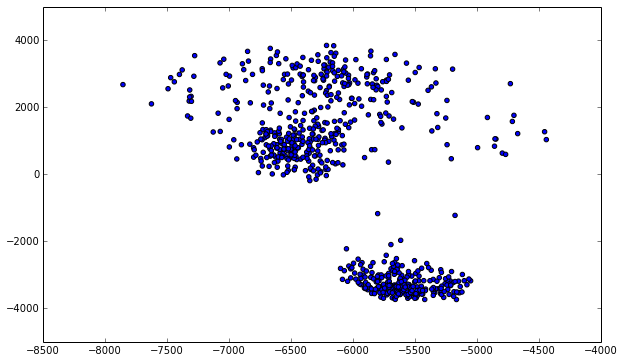

Las dos componentes principales explican un 0.823584335375 de los datos.


In [7]:
pca2 = np.dot(dataset, vectors[:,0:2])
plt.figure(figsize=(10,6))
plt.scatter(pca2[:,0], pca2[:,1])
plt.show()
print("Las dos componentes principales explican un",explained_variation(2),"de los datos.")

Como podemos ver las dos componentes principales explican un $82,35\%$ de los datos.
#### b) Gráfico de los tres componentes principales

Se presentan 2 gráficos, el primero muestra la relación entre las tres componentes principales y el segundo, como complemento, muestra como se relaciona segunda y la tercera componente.

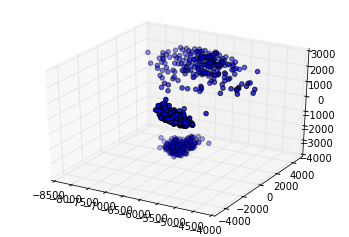

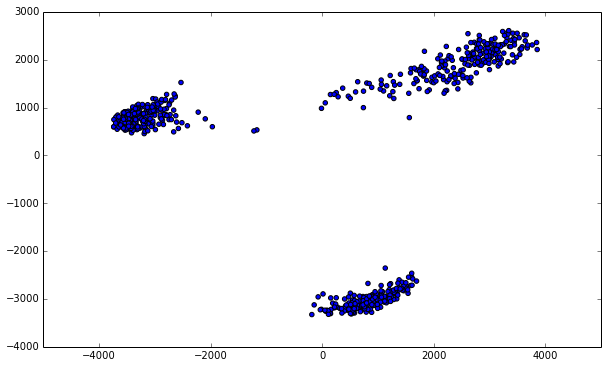

Las tres componentes principales explican un 0.904184858847 de los datos.


In [8]:
from mpl_toolkits.mplot3d import Axes3D

pca2 = np.dot(dataset, vectors[:,0:3])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca2[:,0], pca2[:,1], pca2[:,2])
plt.show()
plt.figure(figsize=(10,6))
plt.scatter(pca2[:,1], pca2[:,2])
plt.show()
print("Las tres componentes principales explican un",explained_variation(3),"de los datos.")

#### c) Componentes necesarios para explicar el 90% de las varianzas de los datos
Como podemos ver, con solo los primeros tres componentes principales logramos representar más del $90\%$ de las varianzas.

## Conclusiones

Durante este laboratorio se trabajó implementando distintos algoritmos que calculan valores y vectores propios. Se ha estudiado el tiempo que tarda en calcular cada uno de estos algoritmos encontrando cuales de ellos son más rápidos que otros, es decir, tienen menos complejidad computacional.
También se ha modificado un algoritmo para que entregue los primeros k valores y vectores propios permitiendo ahorrar bastante cómputo, algo muy importante en matrices de grandes dimensiones.
Comparamos algunos algoritmos notando las ventajas que tiene Rayleigh Power Iteration con mejor tasa de convergencia pero con mayor complejidad que Power Iteration. Nuestro algoritmo más rápido fue Normalized Simultaneous Iteration en calcular los k primeros valores y vectores propios, esto viene dado por la complejidad computacional de los algoritmos.
Finalmente se puede observar como encontrar los componentes principales que explican la mayor cantidad de las varianzas de los datos nos permite hacer un análisis con muchos menos datos eliminando los que aportan menos información y quedándonos con los que describen mayoritariamente el problema.


## Referencias
<div id='ref1'\> [1] [NumPy v1.10 Manual](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) numpy.linalg.solve. *The solutions are computed using LAPACK routine _gesv*. Revisado 30/10/2015

<div id='ref2'\> [2] [LAPACK Benchmark](http://www.netlib.org/lapack/lug/node71.html). Ver tabla 3.13. Revisado el 30/10/2015